# A model of mussel bed pattern formation

*Van de Koppel, J., Rietkerk, M., Dankers, M. & Herman, P.M.J. 2005 Scale-dependent feedback and regular spatial patterns in young mussel beds. The American Naturalist 165:E66-E77.*

Mussel beds are a prominent feature of intertidal ecosystems. They often occur on the seaward edge of tidal flat. Here, the filter feeding mussels can make optimal use of the algae in the seawater when in enters the tidal flat area during the flood tides.

When a mussel bed is viewed from the air, they reveal a remarkable spatial organization. Mussel beds are strongly banded, with elongated mussel patches of 2-3 meters across alternating the open, bare areas of 3-4 meters.

![title](Images/mussels-bar.jpg "Mussel bed patterns in the Wadden sea")

To explain pattern formation in mussels, one needs to take into account the two most basic processes that determine mussel live: they need to eat, and they need to be safe. Below, I explain how this works.

Mussels make a living by consuming the microalgae – diatoms for the most – from the lower water layers of the water column. In dense beds, this can lead to fierce competition among the mussels for the algal food. Luckily for the mussels, the water flow, bringing fresh food for a long as the incoming tides flow.

There are two imminent dangers threatening the life of a mussel. The first is being eaten by birds or sea stars, the second is being washed away from their favourite habitat. They protect themselves against the danger by attaching themselves to other mussels using byssal threads, forming extensive mats of mussels. This means that mussels are more safe as there are more fellow mussels around.

A simple model suffices to show that the interaction of algal competition and density- dependent mortality can explain the formation patterns in mussels. This model describes the interaction of the concentration of algae $A$ in the lower water layer, and the biomass of mussels $M$ on the tidal flat:

$$
\begin{aligned}
\frac{\partial A}{\partial t}&= (A_{up}-A)f - \frac{c}{h}AM - V\nabla_{y} A \\
\frac{\partial M}{\partial t}&= ecAM - d_{M}\frac{k_{M}}{k_{M}+M}M + D \Delta M
\end{aligned}
$$

Here, $A_{up}$ is the concentration of algae in the upper water layer, $f$ is the exchange rate of water between the upper and lower water layer, $c$ is a consumption constant, $h$ is the depth of the lower water layer, $V$ is the advection rate of the water, $e$ is the assimilation efficientcy of the algal material into mussel tissue, $d_{M}$ is the mortality rate for isolated mussels, $k_{M}$ is the mussel density for which mortality has dropped by half, and finally $D$ is the dispersal constant for the mussels.

For more details, see the paper [here](https://pure.knaw.nl/ws/files/466748/VandeKoppel_ea_3467.pdf)

Below we implement this model in iPython.

### Loading some crucial python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import time
%matplotlib inline

# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Parameter definitions 

Here, the parameters that are found in the equations are given their value. For completeness, also their units and explanations are given.

In [2]:
# Algal Exchange parameters
Aup      =  1.2       # g/m3     Algal concentration in upper layer  Oosterschelde data
h        =  0.10      # m        Height of the lower layer  defined
f        =  100.0     # m3/m3/h  Phichange rate with upper layer  Guestimated

# Mussel update, growth & mortality parameters
c        =  0.1       # g/g/h    Maximal consumption rate of the mussels  Riisgard 2001
e        =  0.2       # g/g      Trophic efficiency of mussels  Lamie
dM       =  0.02      # g/g/h    Density dependent mortality rate of the mussels  Calibrated
kM       =  150.0     # g/m2     Effect of density on mortality  Guestimated

# Spatial movement parameters
D        =  0.0005    # m2/h     The diffusion constant describing the movement of mussels
V        =  0.1*60*60 # m/h      Tidal advection constant(0.1 m/s * 60 sec * 60 min)

### Mussel acceleration factor 
Mussel growth occurs on vastly different timescale then water flow. Water flow occurs at a timescale of seconds, while a mussel bed develops at the timescale of months. To avoid enormously long simulation times, we accelerate mussel growth, mortality, and dispersal by multiplying the mussel differential equation with a factor $\phi$ (Phi).  

In [3]:
Phi      =  1000.0    # Speeding constant, accelerates mussel growth

### Parameters that determine how the simulation is run

In [4]:
LengthX   =  75.0     # Length of the physical landscape in the x dimension
LengthY   =  50.0     # Length of the physical landscape in the y dimension
Grid_Width  = 768     # Width of the grid
Grid_Height = 512     # Height of the grid

EndTime  = 180*24/Phi # total time
NumPlots = 180        # Number of times the figure is updated
dt       = 0.0002     # time step

### Some pre-computations

In [5]:
dX = LengthX/Grid_Width  # Space step in X
dY = LengthY/Grid_Height # Space step in Y
n  = int(EndTime/dt)     # The number of simulation iterations

### Colormap definitions
Creates a nice colormap from the color of wet mud (yellow-gray) to the color of dry mud with shells (whitish) to the dark color of the mussels themselves (assuming zero barnacle cover).

In [6]:
MusselColors = [(0.70, 0.67, 0.62), (0.96, 0.91, 0.93), (0.64, 0.64, 0.71),
                (0.44, 0.48, 0.56), (0.20, 0.27, 0.28), (0.00, 0.00, 0.00)]
MusselMap = LinearSegmentedColormap.from_list('MusselColors', MusselColors, N=100)

### Defining derivatives
Here, either a script file is imported (1st cell, inactive), or the second cell below is run. That cell containes as good as the same functions as the "SpatialFunctions_Numba.py" code file, more than is needed for the current simulation. It is intended for general use. When you activate the cell below (set it to code in the menu above), the long functions cell below it can be deleted.

In [7]:
from numba import njit, prange

Forward  = 1
Backward = 2
Central  = 3
DifferenceScheme = Backward
    
@njit(parallel=True)
def d_dx(z,c,r): 
    global DifferenceScheme
    if (DifferenceScheme == Forward):
        dz_dx = ( ( z[c+1,r] - z[c,r] )/dX )
    elif (DifferenceScheme == Backward):
        dz_dx = ( ( z[c,r] - z[c-1,r] )/dX )
    elif (DifferenceScheme == Central):
        dz_dx = ( ( z[c+1,r] - z[c-1,r] )/2.0/dX )        
    return dz_dx

@njit(parallel=True)
def d_dy(z,c,r): 
    global DifferenceScheme
    if (DifferenceScheme == Forward):
        dz_dy = ( ( z[c,r+1] - z[c,r] )/dY )
    elif (DifferenceScheme == Backward):
        dz_dy = ( ( z[c,r] - z[c,r-1] )/dY )
    elif (DifferenceScheme == Central):
        dz_dy = ( ( z[c,r+1] - z[c,r-1] )/2.0/dY )        
    return dz_dy

@njit(parallel=True)
def d2_dxy2(z,c,r):   # (Array z, Column c, Row r)
    return  (z[c-1,r] + z[c+1,r] - 2.0*z[c,r])/dX/dY + \
            (z[c,r-1] + z[c,r+1] - 2.0*z[c,r])/dY/dY 

# Periodic Boundary conditions function

@njit(parallel=True)
def PeriodicBoundaries(z,c,r):
    if  (r==0):             # Lower boundary
        z[c,r] = z[c,Grid_Height-2]
    elif(r==Grid_Height-1): # Upper boundary
        z[c,r] = z[c,1]
    elif(c==0):             # Left boundary
        z[c,r] = z[Grid_Width-2,r]
    elif(c==Grid_Width-1):  # Right boundary
        z[c,r] = z[1,r]

# Neumann Boundary conditions function, having zero flux on the edge

@njit(parallel=True)
def NeumanBoundaries(z,c,r):
    if  (r==0):             # Lower boundary
        z[c,r]=z[c,1]
    elif(r==Grid_Height-1): # Upper boundary
        z[c,r]=z[c,Grid_Height-2];
    elif(c==0):             # Left boundary
        z[c,r]=z[1,r]
    elif(c==Grid_Width-1):  # Right boundary
        z[c,r]=z[Grid_Width-2,r]

# Reflecting Boundary conditions function, for shallow water equations

@njit(parallel=True)
def ReflectingBoundaries(u,v,c,r): 
    if  (r==0):             # Lower boundary
        u[c,r] = u[c,1]
        v[c,r] =-v[c,1]
    elif(r==Grid_Height-1): # Upper boundary
        u[c,r] = u[c,Grid_Height-2]
        v[c,r] =-v[c,Grid_Height-2]
    elif(c==0):             # Left boundary
        u[c,r] =-u[1,r]
        v[c,r] = v[1,r]
    elif(c==Grid_Width-1):  # Right boundaries
        u[c,r] =-u[Grid_Width-2,r]
        v[c,r] = v[Grid_Width-2,r]

# Persistent Flux Boundary condition function, extrapolating over de boundaries

@njit(parallel=True)
def PersistentFluxBoundaries(z,c,r):
    if  (r==0):             # Lower boundary
        z[c,r] = 2*z[c,1] - z[c,2]
    elif(r==Grid_Height-1): # Upper boundary
        z[c,r] = 2*z[c,Grid_Height-2] - z[c,Grid_Height-3]
    elif(c==0):             # Left boundary
        z[c,r] = 2*z[1,r] - z[2,r]
    elif(c==Grid_Width-1):  # Right boundary
        z[c,r] = 2*z[Grid_Width-2,r] - z[Grid_Width-3,r]

# Dirichlet Boundary condition function, having fixed values on the edge

@njit(parallel=True)
def DirichletBoundaries(z,c,r):
    if  (r==0):             # Lower boundary
        z[c,r]=Value
    elif(r==Grid_Height-1): # Upper boundary
        z[c,r]=Value
    elif(c==0):             # Left boundary
        z[c,r]=Value
    elif(c==Grid_Width-1):  # Right boundary
        z[c,r]=Value

### Initializing the data arrays and giving them starting values

In [8]:
np.random.seed(10)
A = np.zeros((Grid_Width, Grid_Height))+0.5
M = 100.0 + (np.random.rand(Grid_Width, Grid_Height)<0.05)*100.0

### Main Simulation Kernel

In [9]:
from numba import njit, prange

@njit(parallel=True)
def SimulationKernel(Am,Mm):
    for row in prange(Grid_Height):
        for column in prange(Grid_Width):
            if(row > 0 and row < Grid_Height-1 and column > 0 and column < Grid_Width-1):
                A=Am[column,row]; M=Mm[column,row]
                dAdt = (Aup-A)*f - c/h*A*M - V*d_dy(Am,column,row)
                dMdt = e*c*A*M - dM*M*kM/(kM+M) + D * d2_dxy2(Mm,column,row)
                A = A + dt * dAdt
                M = M + dt * Phi * dMdt 
                Am[column,row] = A; Mm[column,row] = M 
            else:
                PeriodicBoundaries(Am,column,row)
                PeriodicBoundaries(Mm,column,row)             

### The main simulation loop

In [10]:
# Defining a storage container Ms for all frames
Ms=np.zeros((Grid_Width, Grid_Height, NumPlots))

start_time = time.time() # Starting a timer

# We simulate the PDE with the finite difference method.
for count in range(NumPlots):
    for rep in range(int(EndTime/ dt / NumPlots)):
        SimulationKernel(A,M)

    # We store the state of the system for NumPlot different times.
    Ms[:,:,count] = M

print(" Simulation took      : %1.1f (s)" % (time.time() - start_time))    

 Simulation took      : 107.4 (s)


### Plotting patterns in mussel beds

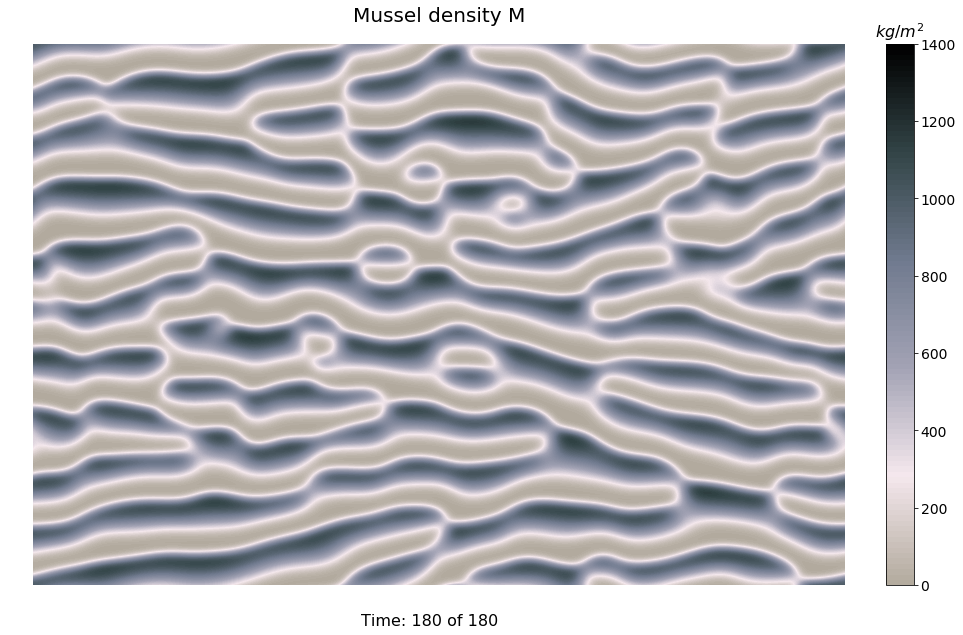

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

im = plt.imshow(Ms[:,:,NumPlots-1].T, animated=True, cmap=MusselMap, clim=(0,1400),
              interpolation='bilinear')
ax.set_axis_off()
text=fig.suptitle("Time: %1.0f of %1.0f" % ((EndTime*Phi/24, EndTime*Phi/24)), x=0.47, y=0.05, fontsize=16);
ax.set_title('Mussel density M', y=1.03, fontsize=20)

f=fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
f.ax.set_title('$kg/m^2$', fontsize=16)
f.ax.tick_params(labelsize=14)

plt.tight_layout(rect=[0, 0.05, 0.94, 1])
fig.savefig('Mussels.png', dpi=120)

### Making an animation
Below, a movie is produced from the simulation results. To get the to work, ffmpeg must be installed (http://ffmpeg.org)

In [12]:
from matplotlib import animation, rc

def updatefig(i): # To update the image at each iteration
    global Ms
    im.set_array(Ms[:,:,i].T)
    text.set_text("Time: %1.0f of %1.0f" % ((i+1)/NumPlots*EndTime*Phi/24, EndTime*Phi/24));
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=100, frames = NumPlots, repeat=False, blit=True)

In [13]:
from IPython.display import HTML
HTML(ani.to_html5_video())

In [14]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('Mussels.mp4', writer=writer, dpi=120)

© Johan van de Koppel, NIOZ-Yerseke 2018